In [444]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm, schur, solve
import os
from sklearn.metrics import f1_score
import json
import pandas as pd
from enum import Enum

Data generation

In [520]:
class MatrixType(Enum):
    """
    Enum representing different available matrices in the data directory
    """
    SCALE_FREE = "Scale_Free_Laplacian"
    ERDOS_RENYI = "Erdos_Renyi_Laplacian"
    SMALL_WORLD = "Small_World_Laplacian"
    GRID_GRAPH = "Grid_Graph_Laplacian"
    BUS_33_MODIFIED = "33bus_modified_ybus"
    WATER_NETWORK = "water_network"

In [446]:
def ensure_positive_definite(M, epsilon=1, min_threshold=1e-3):
    """Ensure M is well-conditioned ; add small value to diagonal if needed"""
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
    
    return M

In [518]:
def build_laplacian(adj_matrix):
    """
        Build an unweighted laplacian matrix given adjacency matrix
    """
    # Binary adjacency matrix
    A = (adj_matrix != 0).astype(int)
    np.fill_diagonal(A, 0)
    
    # Off diagonal degrees
    D = np.diag(np.sum(A, axis=1))
    
    # Laplacian = D - A
    L = D - A
    return L

In [554]:
def load_B(matrix_type: MatrixType, data_dir='Data'):
    """
    Load a specific matrix from Data directory
    """
    matrix_name = matrix_type.value
    file_path = os.path.join(data_dir, matrix_name + '.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Matrix file '{matrix_name}' not found in {data_dir}.")

    B = pd.read_csv(file_path, header=None).values  # Into a Numpy array

    return B

In [448]:
for matrix_type in MatrixType:
    B = load_B(matrix_type)
    print(f'Is {matrix_type.value} symmetric: {la.issymmetric(B)}')

Is 33bus_modified_ybus symmetric: True
Is water_network symmetric: True


array([ 3.27754201e+01,  1.69809506e+01,  1.79782489e+01,  1.22495820e+01,
        7.71228886e+00,  7.11535602e+00,  6.46981763e+00,  6.30719391e+00,
        5.79786217e+00,  5.59990891e+00,  5.05771344e+00,  4.81654284e+00,
        4.12226926e+00,  3.71834568e+00,  3.08426973e+00,  2.68156607e+00,
        2.50744453e+00,  2.22879519e+00,  2.24569834e+00,  1.89665753e+00,
        1.57020037e+00,  1.32575561e+00,  1.22598470e+00,  8.71440448e-01,
        6.14314108e-01,  4.87780735e-01,  3.90579654e-01,  2.86011421e-01,
       -2.50112743e-15,  2.39266847e-02,  5.33876328e-02,  1.20602304e-01,
        1.70488429e-01])

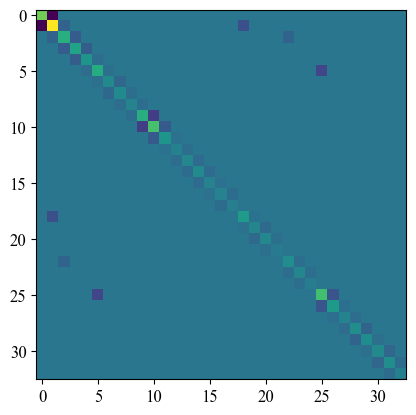

In [451]:
Btrue = load_B(matrix_type=MatrixType.BUS_33_MODIFIED)
plt.imshow(Btrue)
# generate_sparse_covariance(load_B(matrix_type=MatrixType.BUS_33_MODIFIED))
np.linalg.eigvals(Btrue)

In [471]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """

    n = len(B)

    # Mask diagonal of B matrix
    B_no_diag = B.copy()
    np.fill_diagonal(B_no_diag, 0)

    # Now count the number of non-zero elements per row (true degree)
    d = np.max(np.sum(B_no_diag != 0, axis=1))
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # TODO: confirm if np.real is causing any trouble
    L = np.real(la.sqrtm(E))

    # Generate N samples Y ~ N(0, E)
    y_samples = L.dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Max degree in B 3


Text(0.5, 1.0, 'Sample covariance')

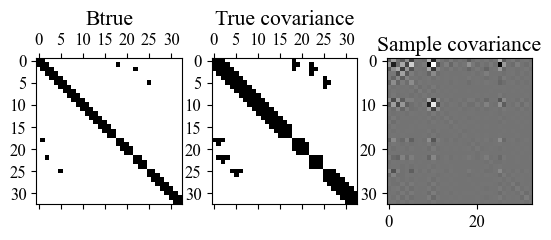

In [479]:
B = load_B(MatrixType.BUS_33_MODIFIED)
S, N = generate_sparse_covariance(B, sample_scaling=100)
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
plt.spy(B@B)
plt.title("True covariance")
plt.subplot(1,3,3)
plt.imshow(np.linalg.inv(S), 'gray')
plt.title("Sample covariance")
# |

Algorithm

In [480]:
def sylvester(A, B, Q):
    """
    Solves the Sylvester equation AX + XB = Q
    """
    m, n = Q.shape

    # Complex Schur decompositions
    A1, U = schur(A, output='complex')
    B1, V = schur(B.T, output='complex') 
    
    # Transform Q
    Q1 = U.conj().T @ Q @ V

    # Initialize solution
    X = np.zeros((m, n), dtype=complex)

    # Solve column-by-column from right to left
    X[:, n-1] = solve(A1 + B1[n-1, n-1] * np.eye(m), Q1[:, n-1])
    for i in range(n-2, -1, -1):
        v = Q1[:, i] - X[:, i+1:n] @ B1[i, i+1:n].T
        X[:, i] = solve(A1 + B1[i, i] * np.eye(m), v)

    # Back-transform solution
    X = U @ X @ V.T

    return X


In [583]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        print(f'Nare X : {X}, H: {H}')
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        # if k % 5 == 0:  # Print every 5 iterations
        #     print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return (X+np.transpose(X))/2

In [572]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [573]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [574]:
def check_symmetric(matrix: np.ndarray, tol=1e-8):
    if not isinstance(matrix, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    if matrix.ndim != 2 or matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square.")
    if not np.allclose(matrix, matrix.T, atol=tol):
        raise ValueError("Matrix is not symmetric.")

In [575]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        print(f"Is A2 negative definite: {np.min(np.linalg.eigvals(-A2)) > 0}")
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)
        if(not la.issymmetric(B_new)):
           raise ValueError("Matrix B_new is not symmetric.")

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho
        if(not la.issymmetric(Z_new)):
           raise ValueError("Matrix Z_new is not symmetric.")

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)
        if(not la.issymmetric(Lambda_new)):
           raise ValueError("Matrix Lambda_new is not symmetric.")

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [576]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [577]:
B = load_B(matrix_type=MatrixType.BUS_33_MODIFIED)
B = build_laplacian(B)
np.linalg.eigvals(B)

array([4.78430927e+00, 4.46810963e+00, 3.93180088e+00, 3.84825013e+00,
       3.74875862e+00, 3.71353164e+00, 3.46721884e+00, 3.39070610e+00,
       3.27566327e+00, 3.09454678e+00, 3.00000000e+00, 2.79269348e+00,
       2.57361643e+00, 2.34294535e+00, 2.15080413e+00, 2.07087456e+00,
       1.90233778e+00, 1.57695058e+00, 1.39782933e+00, 1.23921973e+00,
       1.04828599e+00, 1.00000000e+00, 7.73791027e-01, 7.25187117e-01,
       5.00572323e-01, 3.60754192e-01, 3.35943577e-01, 2.41381917e-16,
       1.83387114e-02, 3.00706310e-02, 9.88803346e-02, 1.29852166e-01,
       2.08157379e-01])

In [584]:
S, N = generate_sparse_covariance(B, sample_scaling=2.0)
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.16  # Regularization strength
rho = 2.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 3
Is A2 negative definite: False
Nare X : [[ 0.64170984 -0.13550565  0.00336206 ... -0.03432869  0.02132611
   0.02158666]
 [-0.14433145  1.09209704  0.02791759 ...  0.10300153 -0.13248716
  -0.00270977]
 [ 0.02278536  0.04143963  0.9201659  ...  0.09444437 -0.03404084
  -0.0803051 ]
 ...
 [-0.02820151  0.06790028  0.05631656 ...  0.78608477 -0.12475031
  -0.06491434]
 [ 0.01785543 -0.08948818  0.01555657 ... -0.09974283  0.84842324
  -0.17226768]
 [ 0.01852409 -0.04250827 -0.0964352  ... -0.09471179 -0.15816338
   0.72131937]], H: [[-0.35829016 -0.13550565  0.00336206 ... -0.03432869  0.02132611
   0.02158666]
 [-0.14433145  0.09209704  0.02791759 ...  0.10300153 -0.13248716
  -0.00270977]
 [ 0.02278536  0.04143963 -0.0798341  ...  0.09444437 -0.03404084
  -0.0803051 ]
 ...
 [-0.02820151  0.06790028  0.05631656 ... -0.21391523 -0.12475031
  -0.06491434]
 [ 0.01785543 -0.08948818  0.01555657 ... -0.09974283 -0.15157676
  -0.17226768]
 [ 0.01852409 -0.04250827 -0.0964352

C:\Users\rohit\AppData\Local\Temp\ipykernel_11444\965770902.py:12: RuntimeWarning: overflow encountered in matmul
  RX = C + X @ A + D @ X - X @ B @ X
C:\Users\rohit\AppData\Local\Temp\ipykernel_11444\965770902.py:12: RuntimeWarning: invalid value encountered in matmul
  RX = C + X @ A + D @ X - X @ B @ X


ValueError: array must not contain infs or NaNs

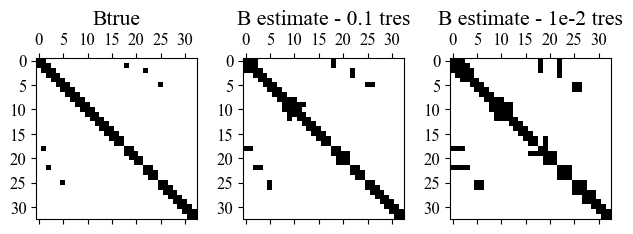

In [550]:
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")
plt.show()

Experimentation

In [502]:
def evaluate_f1_vs_lambda(
        lambda_values, B, sample_scaling=1.0,
        rho=1.0, max_iter=100, tol=1e-4,
        threshold=1e-4, save_plots = False, log_dir="experiment_logs"):
    """
    Evaluate f1 scores, 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # Generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    metrics = {
        "lambda": [],
        "f1": [],
    }

    for lambda_ in lambda_values:
        # Estimate precision matrix with user-defined ADMM function
        B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        if save_plots:
            # Plot and save the sparsity patterns (optional, can remove if not needed)
            plt.figure(figsize=(6, 12))
            
            plt.subplot(1, 2, 1)
            plt.spy(B)
            plt.title("B (True)", fontsize=16)

            plt.subplot(1, 2, 2)
            plt.spy(B_est_thresholded)
            plt.title("B_est (Estimated)", fontsize=16)

            plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
            plt.savefig(plot_path)
            plt.close()
            
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        f1 = f1_score(gt_offdiag, pred_offdiag)

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["f1"].append(f1)

    return metrics

In [503]:
# Updated main loop
sample_scaling = 2
matrix_type = MatrixType.GRID_GRAPH
B = load_B(matrix_type)
print(f'Is B pd: {np.min(np.linalg.eigvals(B))>0}')

log_dir = f"experiment_logs/{matrix_type._value_}/{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0,0.3, 10).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 2.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 1e-1,
    "log_dir": log_dir, 
    "save_plots": True
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_f1_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_f1 = metrics_df["f1"].max()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best f1 scores = {best_f1}")
print(f"Best lambda by f1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["lambda"], metrics_df["f1"])

plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.title("Metrics vs. F1")
plt.legend()
plot_path = os.path.join(log_dir, "f1_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Is B pd: True
Evaluating metrics for {'lambda_values': [0.0, 0.03333333333333333, 0.06666666666666667, 0.1, 0.13333333333333333, 0.16666666666666666, 0.2, 0.23333333333333334, 0.26666666666666666, 0.3], 'B': [[1.0, -0.45, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.45, 1.45, -0.45, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -0.45, 1.45, -0.45, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -0.45, 1.45, -0.45, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.45, 1.45, -0.45, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best f1 scores = 0.98989898989899
Best lambda by f1 = 0.100


F1 vs scaling 

In [504]:
plt.rcParams.update({
    "text.usetex": False,         
    "font.family": "serif",        
    "font.serif": ["Times New Roman", "Times"],
    "axes.labelsize": 14,
    "font.size": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})


In [516]:

def plot_f1_vs_sample_scaling(
    best_lambda=0.25862068965517243,
    rho=4.0,
    max_iter=200,
    tol=1e-4,
    threshold=1e-1,
    scaling_values=[0.2, 0.5, 1, 1.5, 2, 5, 70],
    num_trials=10,
    log_dir="experiment_scale_logs"
):
    """
    Fix parameters (n, alpha, best_lambda, etc.) and update sample_scaling from
    to see how F1 improves with more samples for different d values
    """    
    
    os.makedirs(log_dir, exist_ok=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    
    results_f1 = []
    results_error = []

    markers = {
        MatrixType.GRID_GRAPH: "o",
        MatrixType.SMALL_WORLD: "s",
        MatrixType.SCALE_FREE: "D",
        MatrixType.ERDOS_RENYI: "^"
        # MatrixType.BUS_33_MODIFIED: "o",
        # MatrixType.WATER_NETWORK: "^"
    }
    linestyles = {
        MatrixType.GRID_GRAPH: "dashed",
        MatrixType.SMALL_WORLD: "dashdot",
        MatrixType.SCALE_FREE: "dotted",
        MatrixType.ERDOS_RENYI: "solid"
        # MatrixType.BUS_33_MODIFIED: "dashed",
        # MatrixType.WATER_NETWORK: "dashdot",
    }
    
    for matrix_type in MatrixType:
        f1_scores = []
        worst_case_errors = []
        B = load_B(matrix_type)

         # Ground-truth adjacency (full)
        ground_truth_adjacency = (B != 0).astype(int)
        # Exclude diagonals via a mask
        mask_offdiag = ~np.eye(len(B), dtype=bool)
        
        for scale in scaling_values:
            print(f'Matrix type: {matrix_type.name}, scale: {scale}')
            _f1_scores = []
            _max_errors = []
            for _ in range(num_trials):
                # Generate data with the current scale
                S, N = generate_sparse_covariance(B, sample_scaling=scale)
                
                # Estimate precision matrix using the best param config
                B_est = admm_precision_matrix(S, best_lambda, rho, max_iter, tol)
                
                # Threshold the estimate
                B_est_thresholded = hard_threshold(B_est, threshold)
                
                predicted_adjacency = (B_est_thresholded != 0).astype(int)
                gt_offdiag = ground_truth_adjacency[mask_offdiag]
                pred_offdiag = predicted_adjacency[mask_offdiag]

                f1 = f1_score(gt_offdiag, pred_offdiag)
                _f1_scores.append(f1)
                # Compute absolute difference matrix
                abs_diff = np.abs(B_est - B)
                # Set diagonal entries to zero to exclude them
                np.fill_diagonal(abs_diff, 0)
                # Row-wise L1 norm (sum across columns)
                row_l1_norms = np.sum(abs_diff, axis=1)
                # Take the maximum row-wise L1 norm
                max_error = np.max(row_l1_norms)
                _max_errors.append(max_error)
            
            f1_scores.append(np.mean(_f1_scores))
            worst_case_errors.append(np.mean(_max_errors))
            print(f"scale={scale}, #samples={N}, F1={np.average(_f1_scores):.3f}")
        
        # results_f1.append(pd.DataFrame({"sample_scaling": scaling_values, "F1": f1_scores}))
        # results_error.append(pd.DataFrame({"sample_scaling": scaling_values, "Error": worst_case_errors}))
        axs[0].plot(scaling_values, f1_scores, label=matrix_type.name, marker=markers[matrix_type], linestyle=linestyles[matrix_type])
        axs[1].plot(scaling_values, worst_case_errors, label=matrix_type.name, marker=markers[matrix_type], linestyle=linestyles[matrix_type])
    
    # df = pd.concat(results, ignore_index=True)
    # Save to CSV
    # csv_path = os.path.join(log_dir, f"f1_vs_scaling_threshold_{threshold}.csv")
    # df.to_csv(csv_path, index=False)
    
    # Plot
    axs[0].set_xlabel(r"$n/(d^2 \log p)$", fontsize=13)
    axs[0].set_ylabel("Average F-score", fontsize=13)
    # axs[0].set_title("Average F-score", fontsize=14)
    axs[0].legend(fontsize=11)
    axs[0].grid(True)

    axs[1].set_xlabel(r"$n/(d^2 \log p)$", fontsize=13)
    axs[1].set_ylabel(r"$\left\|\hat{\Delta}_B - \Delta_B^*\right\|_{\infty}$", fontsize=13)
    # axs[1].set_title("Worst case error bound", fontsize=14)
    axs[1].grid(True)

Matrix type: SCALE_FREE, scale: 0.2
Max degree in B 10
ADMM Converged after 146 iterations.
Max degree in B 10
ADMM Converged after 143 iterations.
Max degree in B 10
ADMM Converged after 149 iterations.
Max degree in B 10
ADMM Converged after 154 iterations.
Max degree in B 10
ADMM Converged after 151 iterations.
Max degree in B 10
ADMM Converged after 130 iterations.
Max degree in B 10
ADMM Converged after 147 iterations.
Max degree in B 10
ADMM Converged after 147 iterations.
Max degree in B 10
ADMM Converged after 153 iterations.
Max degree in B 10
ADMM Converged after 148 iterations.
scale=0.2, #samples=68, F1=0.877
Matrix type: SCALE_FREE, scale: 0.5
Max degree in B 10
ADMM Converged after 153 iterations.
Max degree in B 10
ADMM Converged after 151 iterations.
Max degree in B 10
ADMM Converged after 150 iterations.
Max degree in B 10
ADMM Converged after 153 iterations.
Max degree in B 10
ADMM Converged after 152 iterations.
Max degree in B 10
ADMM Converged after 151 iterations.

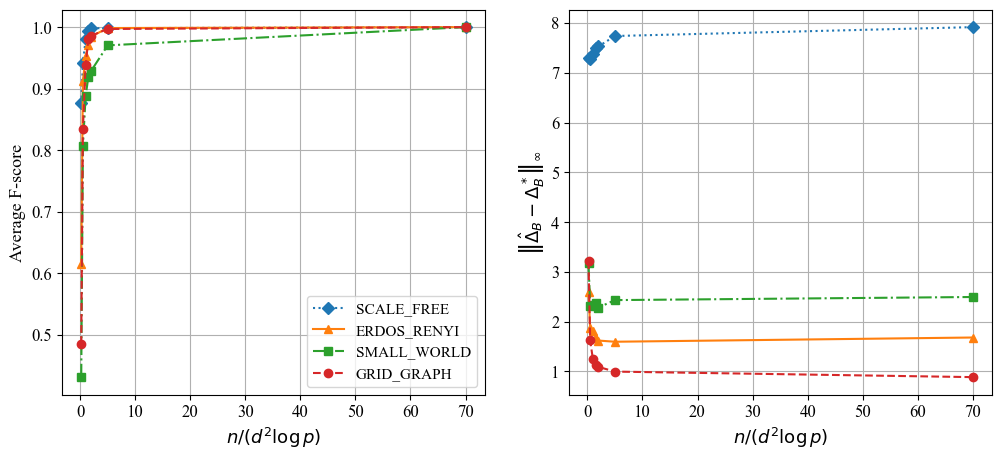

In [517]:
plot_f1_vs_sample_scaling()